In [26]:
# load the required modules
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import cv2
import os
import csv
import argparse
import scipy.misc

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization,Input
from keras.layers import Conv2D, MaxPooling2D,MaxPooling3D, GlobalAveragePooling2D
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [27]:
# coding: utf-8

'''
This script creates 3-channel gray images from FER 2013 dataset.
It has been done so that the CNNs designed for RGB images can 
be used without modifying the input shape. 
It generates the images and saves them in three directories inside 
the output directory - Training, PublicTest, and PrivateTest. 
These are the three original splits in the dataset. 

File and output folder are the below variables.
'''
file = 'fer2013.csv'
output_folder = 'data'

w, h = 48,48
image = np.zeros((h, w), dtype=np.uint8)
id = 1
emotion_list = []
with open(file, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    headers = next(reader)
    for row in reader:  
        #fetching emotion
        emotion = row[0]
        #fetching the pixels of the image
        pixels = np.array(list(map(int, row[1].split())))
        #fetching the usage catregory of the image - Training/PublicTest/PrivateTest
        usage = row[2]
        
        image = np.reshape(pixels, (w, h))
        image_stack = np.dstack((image,) * 3)
        
        # add emotion to the list
        emotion_list += emotion

        image_folder = os.path.join(output_folder, usage)
        image_folder = os.path.join(image_folder, emotion) 
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        image_file =  os.path.join(image_folder , str(id) + '.jpg')
        scipy.misc.imsave(image_file, image_stack)
        id += 1 
        

np.savetxt("emotions.csv", emotion_list, delimiter=",", fmt='%s')
print("Finished!")

Finished!


In [28]:
# read images from folder
def load_images():
    # training images (1 - 28709 images)
    images_train = []
    for name in range(28710):
        for emo in range(7):
            img = cv2.imread('data/Training/' + str(emo) + '/'+str(name) + '.jpg', 0)
            if img is not None:
                images_train.append(img)

    # validation images (28710 - 32298 images)
    images_val = []
    for name in range(28710, 32299):
        for emo in range(7):
            img = cv2.imread('data/PublicTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_val.append(img)

    # test images (32299 - 35887 images)
    images_test = []
    for name in range(32299, 35888):
        for emo in range(7):
            img = cv2.imread('data/PrivateTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_test.append(img)

    
    
    return images_train, images_val, images_test

In [29]:
# load the images
images_train, images_val, images_test = load_images()

# change to numpy matrix
images_train = np.array(images_train)
images_val = np.array(images_val)
images_test = np.array(images_test)

# save the numpy matrix
np.save('dataset/train_raw.npy', images_train)
np.save('dataset/val_raw.npy', images_val)
np.save('dataset/test_raw.npy', images_test)

In [30]:
# load the images
images_train = np.load('dataset/train_raw.npy')
# load the validation images
images_val = np.load('dataset/val_raw.npy')
# load the test images
images_test = np.load('dataset/test_raw.npy')

In [31]:
# load the corresponding emotion values
emotions = pd.read_csv('emotions.csv', header=None)

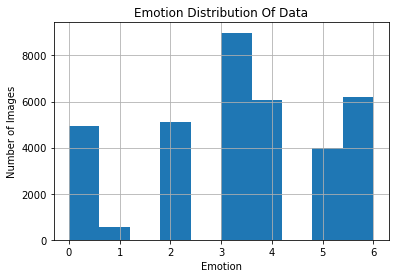

In [32]:
# data distribution
emotions.hist()
plt.title('Emotion Distribution Of Data')
plt.ylabel('Number of Images')
plt.xlabel('Emotion')

In [33]:
# distribution of pictures
emotions[0].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: 0, dtype: int64

In [34]:
# prepare output labels for train, cv and test
y_train = emotions[:images_train.shape[0]].values
y_val = emotions[images_train.shape[0]:images_train.shape[0] + images_val.shape[0]].values
y_test = emotions[images_train.shape[0] + images_val.shape[0]: ].values

In [35]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3589, 1)


In [82]:
# create one hot encoding
y_train_encode = to_categorical(y_train, num_classes=7)
y_val_encode = to_categorical(y_val, num_classes=7)
y_test_encode = to_categorical(y_test, num_classes=7)

In [83]:
print(y_train_encode.shape)
print(y_val_encode.shape)
print(y_test_encode.shape)

(28709, 7)
(3589, 7)
(3589, 7)


In [38]:
# for displaying an image from dataset
def show(img):
    # resize the image
    
    show_image = img.reshape(48,48)
    # show the image
    plt.imshow(show_image, cmap='gray')
   # plt.imshow(img, cmap='gray')

Emotion:[0]


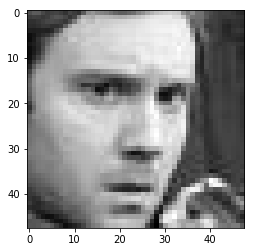

In [39]:
# verify the image with its label
index = 0
# training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:[0]


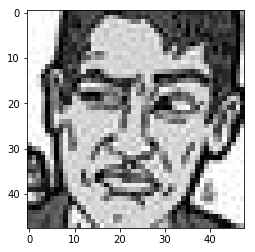

In [40]:
# cv image
show(images_val[index])
print('Emotion:' + str(y_val[index]))

Emotion:[0]


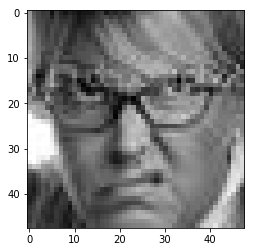

In [41]:
# test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

In [42]:

# reshape the images for keras model
images_train = np.expand_dims(images_train, 3)
images_val = np.expand_dims(images_val, 3)
images_test = np.expand_dims(images_test, 3)

In [43]:
print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [44]:
#from keras.utils import plot_model
#import pydot
#plot_model(model, to_file='model/model.png', show_shapes=True)

In [45]:
# save the model weights after each epoch if the validation loss decreases
checkpoint = ModelCheckpoint(filepath='model/weights_best.hdf5', verbose=1, save_best_only=True)

In [136]:
from keras import regularizers
model = Sequential()

# 1st stage
model.add(Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# 2nd stage
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# 3rd stage
model.add(Conv2D(128, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# FC layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7))
model.add(Activation('softmax'))

In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_73 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 24, 24, 64)        18496     
__________

In [138]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [139]:
# start training the model
hist = model.fit(images_train, y_train_encode, batch_size=128, epochs=5, verbose=1,
          validation_data=(images_val, y_val_encode), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
model.save_weights('model/weights.h5')
model.save('model/model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 2009s - loss: 2.1039 - acc: 0.2349 - val_loss: 1.6572 - val_acc: 0.3561
Epoch 2/5
28709/28709 [==============================] - 2023s - loss: 1.7119 - acc: 0.3471 - val_loss: 1.6232 - val_acc: 0.3787
Epoch 3/5
28709/28709 [==============================] - 4864s - loss: 1.5329 - acc: 0.4110 - val_loss: 1.3886 - val_acc: 0.4692
Epoch 4/5
28709/28709 [==============================] - 1293s - loss: 1.3988 - acc: 0.4603 - val_loss: 1.2992 - val_acc: 0.4971
Epoch 5/5
28709/28709 [==============================] - 1270s - loss: 1.3146 - acc: 0.4982 - val_loss: 1.2801 - val_acc: 0.5096


In [140]:
# training loss and accuracy
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(images_test, y_test_encode,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.498171305176
Validation Accuracy:  0.509612705506
3589/3589 [==============================] - 62s    
Test score: 1.27152149131
Test accuracy: 0.514349400956


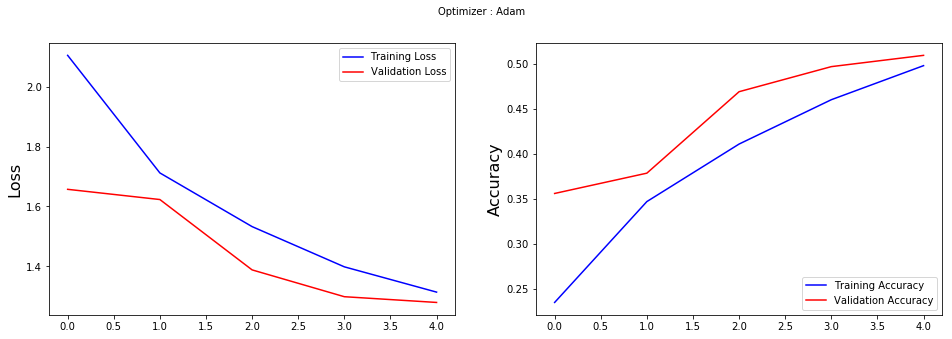

In [141]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [142]:

refined_model = Sequential()

# 1st stage
refined_model.add(Conv2D(64, 3, input_shape=(48, 48, 1), padding='same', activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(64, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# 2nd stage
refined_model.add(Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(128, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# 3rd stage
refined_model.add(Conv2D(256, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# FC layers
refined_model.add(Flatten())
refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(7))
refined_model.add(Activation('softmax'))

refined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_82 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_83 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [143]:
# compile the model
refined_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# start training the model
refined_hist = refined_model.fit(images_train, y_train_encode, batch_size=128, epochs=5, verbose=1,
          validation_data=(images_val, y_val_encode), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
refined_model.save_weights('model/refined-weights.h5')
refined_model.save('model/refined-model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 4868s - loss: 1.8349 - acc: 0.3299 - val_loss: 1.6344 - val_acc: 0.3589
Epoch 2/5
28709/28709 [==============================] - 11470s - loss: 1.4271 - acc: 0.4552 - val_loss: 1.3797 - val_acc: 0.4606
Epoch 3/5
28709/28709 [==============================] - 3369s - loss: 1.2597 - acc: 0.5220 - val_loss: 1.3568 - val_acc: 0.4745
Epoch 4/5
28709/28709 [==============================] - 3277s - loss: 1.1551 - acc: 0.5628 - val_loss: 1.2146 - val_acc: 0.5403
Epoch 5/5
28709/28709 [==============================] - 3277s - loss: 1.0941 - acc: 0.5870 - val_loss: 1.1751 - val_acc: 0.5550


In [144]:
# training loss and accuracy
train_acc_refined = refined_hist.history['acc']
val_acc_refined = refined_hist.history['val_acc']
print('Training Accuracy: ', train_acc_refined[-1])
print('Validation Accuracy: ', val_acc_refined[-1])

# test loss and accuracy
refined_score, refined_acc = refined_model.evaluate(images_test, y_test_encode,
                            batch_size=32)
print('Test score:', refined_score)
print('Test accuracy:', refined_acc)

Training Accuracy:  0.586958793372
Validation Accuracy:  0.555029256093
3589/3589 [==============================] - 158s   
Test score: 1.13674361429
Test accuracy: 0.577040958488


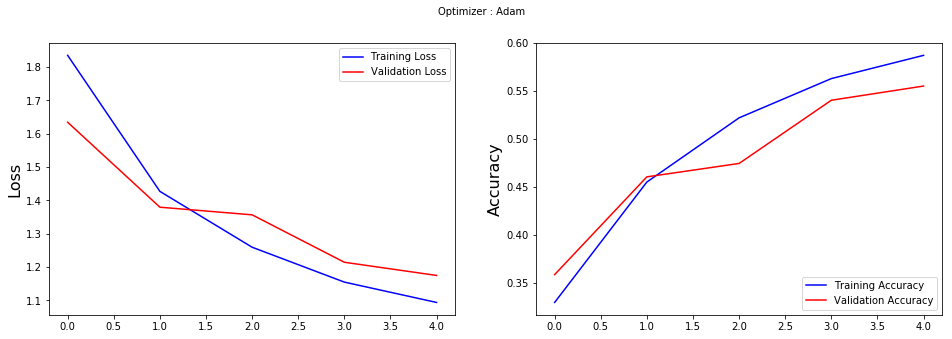

In [145]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(refined_hist.history['loss'], color='b', label='Training Loss')
plt.plot(refined_hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(refined_hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(refined_hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [177]:
# read image 
images = []
for filename in os.listdir('test_images\\'):
    path = os.path.join('test_images\\', filename)
    images.append(cv2.imread(path, -1))

In [178]:
# do prediction for the images after resizing them
predictions = []
for img in images:
    # change to greyscale
    curr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    curr_img = cv2.resize(curr_img, (48,48))
    curr_img = np.reshape(curr_img, (1, 48, 48, 1))
    predictions.append(np.argmax(refined_model.predict(curr_img)))
  

In [179]:
# list of given emotions
EMOTIONS = ['Angry', 'Disgusted', 'Fearful',
            'Happy', 'Sad', 'Surprised', 'Neutral']

In [180]:
# bgr to rgb
for i in range(1):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [181]:
# to display the predicted emotion and the original image
def predict_emotion(i):
    plt.imshow(images[i])
    print('Predicted Emotion: ' + str(EMOTIONS[predictions[i]]))
    plt.show()

Predicted Emotion: Angry


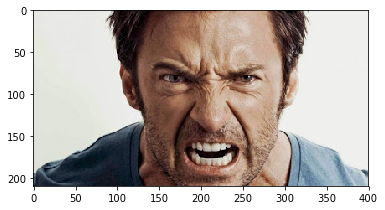

Predicted Emotion: Happy


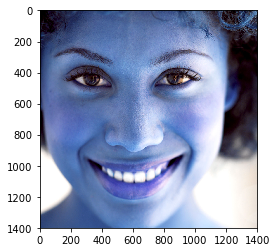

Predicted Emotion: Sad


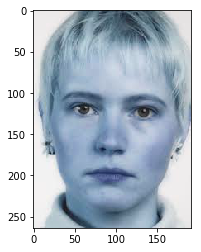

Predicted Emotion: Sad


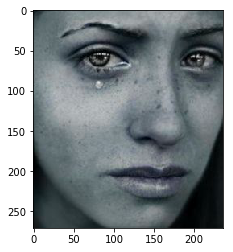

In [182]:
for i in range (len(images)):
    predict_emotion(i)
